# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [398]:
# Importing necessary modules.

import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
# % matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Exploratory Data Analysis

In [399]:
# data wrangling.
# df = transaction
# df = portfolio
df = profile
# df.head()
# df.tail()
# df.describe()
# df.info()
df.isna().sum() / df.shape[0] * 100 

age                  0.000000
became_member_on     0.000000
gender              12.794118
id                   0.000000
income              12.794118
dtype: float64

Seems like, 12% of gender and income data is null. 

In [400]:
# cleaning portfolio data
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [401]:
df = portfolio
from helper import column_exploder
df = column_exploder(df, 'channels').copy()

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [402]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward,mobile,web,social,email
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,1,0,1


In [403]:
import copy
df = copy.deepcopy(portfolio)
df2 = df
df['offer_type_list'] = df['offer_type'].apply(lambda x: [x])
df = column_exploder(df, 'offer_type_list').copy()
df.drop(columns = ['channels','offer_type', 'offer_type_list'], inplace=True)
portfolio_cleaned = copy.deepcopy(df)
portfolio_cleaned

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,difficulty,duration,id,reward,mobile,web,social,email,discount,informational,bogo
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,1,1,0,0,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,0,0,1
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,0,1,0,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,0,1,0,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0,1,1,0,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,1,0,0
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,1,0,0
7,0,3,5a8bc65990b245e5a138643cd4eb9837,0,1,0,1,1,0,1,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,0,0,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,2,1,1,0,1,1,0,0


In [404]:
# Cleaning and setting up transcript data
df = copy.deepcopy(transcript)
df.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [405]:
# Let's find the list of unique events in the transcripts dataset.
df['event'].unique().tolist()

['offer received', 'offer viewed', 'transaction', 'offer completed']

In [406]:
# Let's find the count of each unique events in the transcripts dataset.
df.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [407]:
# Setting up transction only dataframe
transaction_event_data = df[df.event == 'transaction'].reset_index().drop(columns='index')
transaction_event_data['amount_value'] = transaction_event_data['value'].apply(lambda x: dict(x)['amount'])
transaction_event_data.drop(columns='value', inplace=True)
transaction_event_data.tail()

,event,person,time,amount_value
138948,transaction,b3a1272bc9904337b331bf348c3e8c17,714,1.59
138949,transaction,68213b08d99a4ae1b0dcb72aebd9aa35,714,9.53
138950,transaction,a00058cf10334a308c68e7631c529907,714,3.61
138951,transaction,76ddbd6576844afe811f1a3c0fbb5bec,714,3.53
138952,transaction,c02b10e8752c4d8e9b73f918558531f7,714,4.05


In [408]:
# Setting up viewed received dataframe
offer_received_data = df[df.event == 'offer received'].reset_index().drop(columns='index')
offer_received_data['offer_id'] = offer_received_data['value'].apply(lambda x: dict(x)['offer id'])
offer_received_data.drop(columns=['value'], inplace=True)
offer_received_data.tail()

,event,person,time,offer_id
76272,offer received,d087c473b4d247ccb0abfef59ba12b0e,576,ae264e3637204a6fb9bb56bc8210ddfd
76273,offer received,cb23b66c56f64b109d673d5e56574529,576,2906b810c7d4411798c6938adc9daaa5
76274,offer received,6d5f3a774f3d4714ab0c092238f3a1d7,576,2298d6c36e964ae4a3e7e9706d1fb8c2
76275,offer received,9dc1421481194dcd9400aec7c9ae6366,576,ae264e3637204a6fb9bb56bc8210ddfd
76276,offer received,e4052622e5ba45a8b96b59aba68cf068,576,3f207df678b143eea3cee63160fa8bed


In [409]:
# Setting up viewed offers dataframe
offer_viewed_data = df[df.event == 'offer viewed'].reset_index().drop(columns='index')
offer_viewed_data['offer_id'] = offer_viewed_data['value'].apply(lambda x: dict(x)['offer id'])
offer_viewed_data.drop(columns=['value'], inplace=True)
offer_viewed_data.tail()

,event,person,time,offer_id
57720,offer viewed,d56386cf344c4829bbf420d1895dca37,714,5a8bc65990b245e5a138643cd4eb9837
57721,offer viewed,9b51e8797290403b90d09d864dec4b94,714,3f207df678b143eea3cee63160fa8bed
57722,offer viewed,84fb57a7fe8045a8bf6236738ee73a0f,714,5a8bc65990b245e5a138643cd4eb9837
57723,offer viewed,abc4359eb34e4e2ca2349da2ddf771b6,714,3f207df678b143eea3cee63160fa8bed
57724,offer viewed,8dda575c2a1d44b9ac8e8b07b93d1f8e,714,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [410]:
# Setting up completed offers dataframe
offer_completed_data = df[df.event == 'offer completed'].reset_index().drop(columns='index')
offer_completed_data['offer_id'] = offer_completed_data['value'].apply(lambda x: dict(x)['offer_id'])
offer_completed_data.drop(columns=['value'], inplace=True)
offer_completed_data.tail()

,event,person,time,offer_id
33574,offer completed,0c027f5f34dd4b9eba0a25785c611273,714,2298d6c36e964ae4a3e7e9706d1fb8c2
33575,offer completed,a6f84f4e976f44508c358cc9aba6d2b3,714,2298d6c36e964ae4a3e7e9706d1fb8c2
33576,offer completed,b895c57e8cd047a8872ce02aa54759d6,714,fafdcd668e3743c1bb461111dcafc2a4
33577,offer completed,8431c16f8e1d440880db371a68f82dd0,714,fafdcd668e3743c1bb461111dcafc2a4
33578,offer completed,24f56b5e1849462093931b164eb803b5,714,fafdcd668e3743c1bb461111dcafc2a4


In [411]:
# Cleaning up profile dataframe

df = copy.deepcopy(profile)
df[~df.gender.isna()].isna().sum()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

This means there are no null values in profile data.

In [412]:
profile_cleaned = copy.deepcopy(profile)
print(len(set(transaction_event_data.person.tolist())))
print(len(set(profile_cleaned.id.tolist()))) 

16578
17000


In [413]:
profile_cleaned.gender.unique()

array([None, 'F', 'M', 'O'], dtype=object)

In [414]:
# Removing Nan Values
#  - Setting the None/Nan income values to -1
#  - Setting None/Nan gender values to 'O'

profile_cleaned['income'] = pd.Series.fillna(profile_cleaned['income'], -1)
profile_cleaned['gender'] = pd.Series.fillna(profile_cleaned['gender'], 'O')
profile_cleaned.head()

,age,became_member_on,gender,id,income
0,118,20170212,O,68be06ca386d4c31939f3a4f0e3dd783,-1.0
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,O,38fe809add3b4fcf9315a9694bb96ff5,-1.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,O,a03223e636434f42ac4c3df47e8bac43,-1.0


In [415]:
a = len(set(transaction_event_data.person.tolist()) - set(profile_cleaned.id.tolist()))
b = len(set(profile_cleaned.id.tolist()) - set(transaction_event_data.person.tolist()))
print(f'Number of users in profile data, who didn\'t transact at all {b}')
print(f"Number of users id's who transacted but their data is not present inside the profile data. {0}")

Number of users in profile data, who didn't transact at all 422
Number of users id's who transacted but their data is not present inside the profile data. 0


In [416]:
# t = pd.merge(transaction_event_data, df,left_on='person', right_on='id', how='left')
# t.sort_values(by='person').head()
# t.describe()
# t[t['age'].isna()]
# len(t[t['age'].isna()])

In [417]:
transaction_event_data.tail()

,event,person,time,amount_value
138948,transaction,b3a1272bc9904337b331bf348c3e8c17,714,1.59
138949,transaction,68213b08d99a4ae1b0dcb72aebd9aa35,714,9.53
138950,transaction,a00058cf10334a308c68e7631c529907,714,3.61
138951,transaction,76ddbd6576844afe811f1a3c0fbb5bec,714,3.53
138952,transaction,c02b10e8752c4d8e9b73f918558531f7,714,4.05


In [418]:
# finding the count of transactions done by a user 
transaction_counts = transaction_event_data.groupby('person').count().sort_values(by='event', ascending=False)['event'].reset_index().copy()
transaction_counts.rename(columns={'event':'counts'}, inplace=True)
transaction_counts.head()

,person,counts
0,79d9d4f86aca4bed9290350fb43817c2,36
1,8dbfa485249f409aa223a2130f40634a,36
2,94de646f7b6041228ca7dec82adb97d2,35
3,b1f4ece7d49342628a9ed77aee2cde58,32
4,5e60c6aa3b834e44b822ea43a3efea26,32


In [419]:
# finding the total value spent by a user 
# transaction_event_data.groupby('person').sum().sort_values(by='amount_value', ascending=False)['amount_value'].copy()
transaction_revenue = transaction_event_data.groupby('person').sum().sort_values(by='amount_value', ascending=False)['amount_value'].reset_index().copy()
transaction_revenue.rename(columns={'amount_value':'revenue'}, inplace=True)
transaction_revenue.head()

,person,revenue
0,3c8d541112a74af99e88abbd0692f00e,1608.69
1,f1d65ae63f174b8f80fa063adcaa63b7,1365.66
2,ae6f43089b674728a50b8727252d3305,1327.74
3,626df8678e2a4953b9098246418c9cfa,1321.42
4,73afdeca19e349b98f09e928644610f8,1319.97


In [420]:
# Consolidating transaction count and revenue data for each user/person. 
transaction_revenue_summary = pd.merge(transaction_counts, transaction_revenue, on='person', how='inner')
transaction_revenue_summary.head()

,person,counts,revenue
0,79d9d4f86aca4bed9290350fb43817c2,36,173.41
1,8dbfa485249f409aa223a2130f40634a,36,76.46
2,94de646f7b6041228ca7dec82adb97d2,35,90.23
3,b1f4ece7d49342628a9ed77aee2cde58,32,133.02
4,5e60c6aa3b834e44b822ea43a3efea26,32,103.66


In [421]:
# Consolidating each user's profile info with the spending info (like transaction counts & spending amount)
user_transaction_summary = pd.merge(transaction_revenue_summary, profile_cleaned, left_on='person', right_on='id', how='inner')
user_transaction_summary.drop(columns='id', inplace=True)
user_transaction_summary.rename({'person':'user_id'}, inplace=True)
user_transaction_summary.head()

,person,counts,revenue,age,became_member_on,gender,income
0,79d9d4f86aca4bed9290350fb43817c2,36,173.41,76,20150423,M,34000.0
1,8dbfa485249f409aa223a2130f40634a,36,76.46,63,20151118,M,48000.0
2,94de646f7b6041228ca7dec82adb97d2,35,90.23,27,20140126,M,33000.0
3,b1f4ece7d49342628a9ed77aee2cde58,32,133.02,37,20180105,M,64000.0
4,5e60c6aa3b834e44b822ea43a3efea26,32,103.66,59,20141120,M,55000.0


In [422]:
def age_bracket_func(x):
    """ Function to map and return the age bracket where the input age. 
    
    Args:
        x {int}: input age
    Returns:
        {str}: age bracket where the input age. 
    """
    if 0 < x < 20:
        return '0-19'
    elif 20 <= x <30:
        return '20-29'
    elif 30 <= x <40:
        return '30-39'
    elif 40 <= x <50:
        return '40-49'
    elif 50 <= x <60:
        return '50-59'
    else:
        return '60+'

# Adding a age bracket column for each user summary
age_split_user_summary = user_transaction_summary.copy()
age_split_user_summary['age_bracket'] = age_split_user_summary['age'].apply(age_bracket_func)
age_split_user_summary.head()

,person,counts,revenue,age,became_member_on,gender,income,age_bracket
0,79d9d4f86aca4bed9290350fb43817c2,36,173.41,76,20150423,M,34000.0,60+
1,8dbfa485249f409aa223a2130f40634a,36,76.46,63,20151118,M,48000.0,60+
2,94de646f7b6041228ca7dec82adb97d2,35,90.23,27,20140126,M,33000.0,20-29
3,b1f4ece7d49342628a9ed77aee2cde58,32,133.02,37,20180105,M,64000.0,30-39
4,5e60c6aa3b834e44b822ea43a3efea26,32,103.66,59,20141120,M,55000.0,50-59


count    16578.000000
mean         8.381771
std          5.009822
min          1.000000
25%          5.000000
50%          7.000000
75%         11.000000
max         36.000000
Name: counts, dtype: float64


Text(0.5,0,'Unique Conversions / transactions')

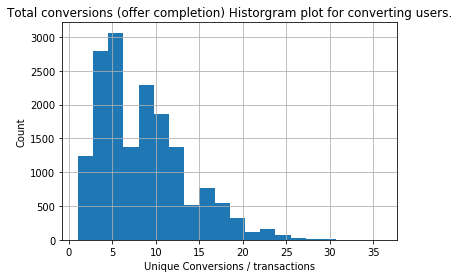

In [423]:
# Plotting histogram for - Total conversions (offer completion) Historgram plot for converting users.

print(age_split_user_summary['counts'].describe())
age_split_user_summary['counts'].hist(bins=20)
plt.title('Total conversions (offer completion) Historgram plot for converting users.')
plt.ylabel('Count')
plt.xlabel('Unique Conversions / transactions')

Observation:
 - Average user transactions count is 8.38

In [424]:
# These users are like 1000 true fans. 
# They enjoy the product & we need not send any offers to them. 

top_converting_users = age_split_user_summary[age_split_user_summary.counts > 11] # taking users > 75 percentile
top_converting_users_id = list(top_converting_users.person.unique())
print("Total Ids", len(top_converting_users_id))
with open('top_converting_user_ids.csv', 'w+') as fd:
    fd.write('ids,\n')
    for x in list(top_converting_users.person.unique()):
        fd.write(f"{x},\n")
print('Writing user list to file.')
print('NOTE: These users are like 1000 true fans. They enjoy the product & we need not send any offers to them. ')

Total Ids 3941
Writing user list to file.
NOTE: These users are like 1000 true fans. They enjoy the product & we need not send any offers to them. 


In [425]:
# These users have converted but has potential to convert more. 
# These user ids can be used for remarketing by offering better offers so that they convert more.

lowest_converting_users = age_split_user_summary[age_split_user_summary.counts < 5] # taking users < 25 percentile
lowers_converting_users_id = list(lowest_converting_users.person.unique())
print("Total Ids", len(lowers_converting_users_id))
with open('lowest_converting_user_ids.csv', 'w+') as fd:
    fd.write('ids,\n')
    for x in list(lowest_converting_users.person.unique()):
        fd.write(f"{x},\n")

print('Writing user list to file.')
print('NOTE: These users have converted but has potential to convert more. These user ids can be used for remarketing by offering better offers so that they convert more.')

Total Ids 4037
Writing user list to file.
NOTE: These users have converted but has potential to convert more. These user ids can be used for remarketing by offering better offers so that they convert more.


count    16578.000000
mean        62.320666
std         26.683230
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64


Text(0.5,0,'Age')

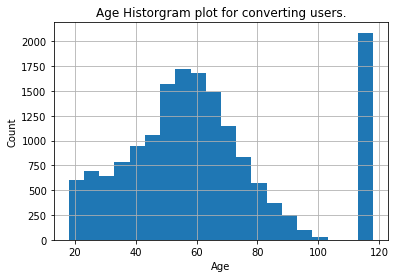

In [426]:
# Plotting histogram for - Age Historgram plot for converting users.

print(age_split_user_summary['age'].describe())
age_split_user_summary.hist(bins=20, column='age')
plt.title('Age Historgram plot for converting users.')
plt.ylabel('Count')
plt.xlabel('Age')

Observation:
 - Average user age 62 years

count     16578.000000
mean      57011.636747
std       29592.609566
min          -1.000000
25%       40000.000000
50%       59000.000000
75%       76000.000000
max      120000.000000
Name: income, dtype: float64


Text(0.5,0,'Income')

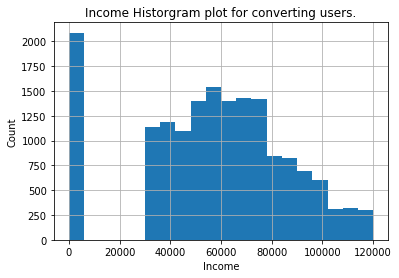

In [427]:
# Plotting histogram for - Income Historgram plot for converting users.

print(age_split_user_summary['income'].describe())
age_split_user_summary['income'].hist(bins=20)
plt.title('Income Historgram plot for converting users.')
plt.ylabel('Count')
plt.xlabel('Income')

Observation:
 - Average user income 57000.

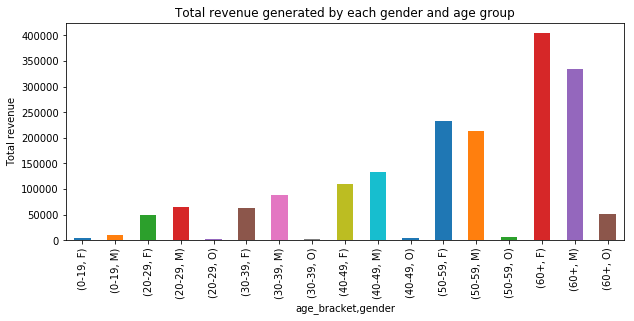

In [428]:
# Plotting bar graph for - Total revenue generated by each gender and age group

plt.figure(figsize=(10,4))
plt.title('Total revenue generated by each gender and age group')
plt.xlabel('Age_bracket & gender')
plt.ylabel('Total revenue')
g = age_split_user_summary.groupby(['age_bracket', 'gender']).sum().copy()
g['revenue'].plot(kind='bar')

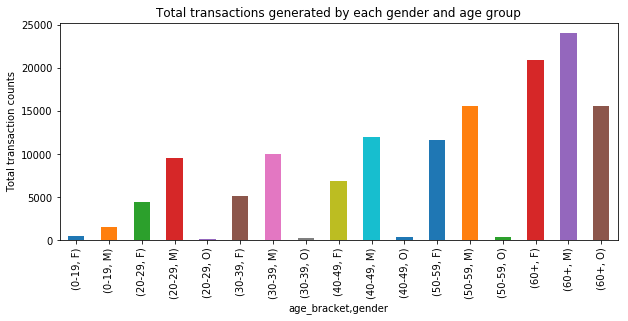

In [429]:
# Plotting bar graph for - Total transactions generated by each gender and age group

plt.figure(figsize=(10,4))
plt.title('Total transactions generated by each gender and age group')
plt.xlabel('Age_bracket & gender')
plt.ylabel('Total transaction counts')
g = age_split_user_summary.groupby(['age_bracket', 'gender']).sum().copy()
g['counts'].plot(kind='bar')

##### Observations:
- Top three two age brackets and gender groups that result in highest number of transactions and in turn revenue are:
  - 60+ Male, 60+ Female
  - 50-59 Male, 50-59 Female
  - 40-49 Male, 40049 Female


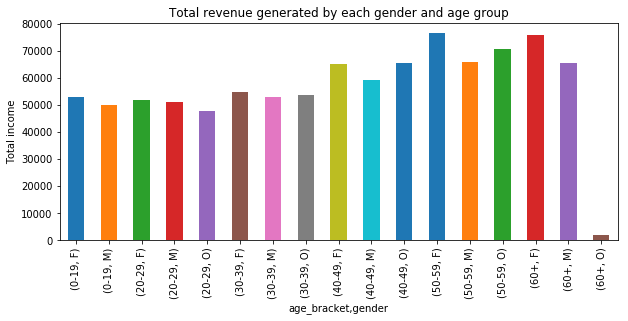

In [430]:
# Plotting bar graph for - Total revenue generated by each gender and age group

plt.figure(figsize=(10,4))
plt.title('Total revenue generated by each gender and age group')
plt.xlabel('Age_bracket & gender')
plt.ylabel('Total income')
g = age_split_user_summary.groupby(['age_bracket', 'gender']).mean().copy()
g['income'].plot(kind='bar')

##### Observation
There is not much difference in income gap between the users who transact based on their age, and gender groups.

### Process
We are going to build a set of heuristics to help decide what offers works best for certain age and gender demographics. We chose a simple approach where the users who converted (completed offer) were analysed based on gender, age, and income bracket.

In [431]:
offer_viewed_data.head()

,event,person,time,offer_id
0,offer viewed,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d
1,offer viewed,d1ede868e29245ea91818a903fec04c6,0,5a8bc65990b245e5a138643cd4eb9837
2,offer viewed,102e9454054946fda62242d2e176fdce,0,4d5c57ea9a6940dd891ad53e9dbe8da0
3,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,ae264e3637204a6fb9bb56bc8210ddfd
4,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,5a8bc65990b245e5a138643cd4eb9837


In [432]:
offer_viewed_data.head()

,event,person,time,offer_id
0,offer viewed,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d
1,offer viewed,d1ede868e29245ea91818a903fec04c6,0,5a8bc65990b245e5a138643cd4eb9837
2,offer viewed,102e9454054946fda62242d2e176fdce,0,4d5c57ea9a6940dd891ad53e9dbe8da0
3,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,ae264e3637204a6fb9bb56bc8210ddfd
4,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,5a8bc65990b245e5a138643cd4eb9837


In [433]:
# Consolidating/mergin offer received, viewed and completed data.

a = pd.merge(offer_received_data, offer_viewed_data, on=['offer_id', 'person'], how='left')
b = pd.merge(a, offer_completed_data, on=['offer_id', 'person'], how='left') 
b = b[['offer_id','person','event_x', 'event_y', 'event', 'time_x', 'time_y', 'time']]
b = b.rename(columns={
    'event_x': 'offer_received',
    'event_y':  'offer_viewed', 
    'event': 'offer_completed', 
    'time_x':'time_received', 
    'time_y':'time_viewed',
    'time': 'time_completed'})

cols = ['offer_received', 'offer_viewed', 'offer_completed']
for col in cols:
    b[col] = b[col].apply(lambda x: 0 if x is np.nan else 1)
    
# There can be cases where the user might not have viewed the offer but still completes it. 
# To avoid this we are going to remove all such conversions from user summary.
b = b[b['offer_viewed'] == 1] 

cols = ['time_received', 'time_viewed', 'time_completed']
for col in cols:
    b[col] = pd.Series.fillna(b[col], np.infty) 

offers_user_summary = copy.deepcopy(b)
offers_user_summary

,offer_id,person,offer_received,offer_viewed,offer_completed,time_received,time_viewed,time_completed
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,1,1,1,0,6.0,132.000000
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac43,1,1,0,0,6.0,inf
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac43,1,1,0,0,624.0,inf
3,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,1,1,0,0,18.0,inf
4,fafdcd668e3743c1bb461111dcafc2a4,8ec6ce2a7e7949b1bf142def7d0e0586,1,1,0,0,12.0,inf
5,fafdcd668e3743c1bb461111dcafc2a4,8ec6ce2a7e7949b1bf142def7d0e0586,1,1,0,0,522.0,inf
6,4d5c57ea9a6940dd891ad53e9dbe8da0,68617ca6246f4fbc85e91a2a49552598,1,1,0,0,84.0,inf
7,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5c,1,1,1,0,0.0,60.000000
8,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5c,1,1,1,0,0.0,600.000000
9,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5c,1,1,1,0,504.0,60.000000


In [434]:
t = offers_user_summary.groupby(['offer_id']).mean().sort_values(by='offer_completed', ascending=False)
t

,offer_received,offer_viewed,offer_completed,time_received,time_viewed,time_completed
offer_id,,,,,,
fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,0.824024,328.912810,348.699405,inf
2298d6c36e964ae4a3e7e9706d1fb8c2,1.0,1.0,0.807954,333.374674,352.683860,inf
9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.780373,329.980425,360.452564,inf
2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.778868,329.330718,356.923499,inf
f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,0.724495,331.604492,350.538443,inf
0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,1.0,0.714067,322.883355,362.699869,inf
ae264e3637204a6fb9bb56bc8210ddfd,1.0,1.0,0.631660,326.402059,352.075161,inf
4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,0.591193,335.045679,354.456950,inf
3f207df678b143eea3cee63160fa8bed,1.0,1.0,0.000000,325.877637,359.091772,inf


In [435]:
top_5_offers = t.index[:5]
portfolio[portfolio.id.isin(top_5_offers)]

,channels,difficulty,duration,id,offer_type,reward,mobile,web,social,email
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


#####  NOTE:
- There can be cases where the user might not have viewed the offer but still completes it. 
- To avoid this we removed all such conversions from user summary.

##### Observations
- 3 out of 5 top offers 
    - were discount offers. And they had high difficulty but low reward.
    - were sent on all 4 channels. 
- 2 out of 5 top offers were bogo offers with medium difficulty and medium reward. 

- Highest offer completion rate (conversion rate) is for the offer: **_fafdcd668e3743c1bb461111dcafc2a4_** (~82%). 
    - We should send this offer more.


##### Metrics - 
For selecting the top offers the metrics we are going to use is the offers which has highest completion rate (conversion rate). As intuitively, we know that the more the conversions the more the revenue increases. 

Based on above metrics:
  - Top Three offers
       - fafdcd668e3743c1bb461111dcafc2a4
       - 2298d6c36e964ae4a3e7e9706d1fb8c2
       - 9b98b8c7a33c4b65b9aebfe6a799e6d9


  - The below mentioned offers didn't result in any conversion. We should stop sending these particular offer. 
     1. 3f207df678b143eea3cee63160fa8bed
     2. 5a8bc65990b245e5a138643cd4eb9837


In [436]:
# Adding age bracket column

# pd.merge(offers_user_summary, age_split_user_summary[['person', 'age', 'became_member_on', 'gender', 'income', 'age_bracket']].dropna(), on='person', how='left')
c = pd.merge(offers_user_summary, profile_cleaned,left_on='person', right_on='id', how='left')
c.drop(columns='id', inplace=True)
c['age_bracket'] = c['age'].apply(age_bracket_func)
c.head()

,offer_id,person,offer_received,offer_viewed,offer_completed,time_received,time_viewed,time_completed,age,became_member_on,gender,income,age_bracket
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,1,1,1,0,6.0,132.000000,75,20170509,F,100000.0,60+
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac43,1,1,0,0,6.0,inf,118,20170804,O,-1.0,60+
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac43,1,1,0,0,624.0,inf,118,20170804,O,-1.0,60+
3,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,1,1,0,0,18.0,inf,68,20180426,M,70000.0,60+
4,fafdcd668e3743c1bb461111dcafc2a4,8ec6ce2a7e7949b1bf142def7d0e0586,1,1,0,0,12.0,inf,118,20170925,O,-1.0,60+


In [437]:
# Adding member joining year.

# c['became_member_on'].isna().sum() 
# All members have joining data in the data.

def year_extractor(x):
    """ Function to extract the year which the user joinined the program. 
    
    Args:
        x {int}: member joined on data in the format yyyymmdd
    Returns:
        {str}: year the member joined on
    """
    return str(x)[:4]

def month_extractor(x):
    """ Function to extract the month which the user joinined the program. 
    
    Args:
        x {int}: member joined on data in the format yyyymmdd
    Returns:
        {str}: month the member joined on
    """
    return str(x)[4:6]

c['joining_year'] = c['became_member_on'].apply(year_extractor)
c['joining_month'] = c['became_member_on'].apply(month_extractor)
c.head()

,offer_id,person,offer_received,offer_viewed,offer_completed,time_received,time_viewed,time_completed,age,became_member_on,gender,income,age_bracket,joining_year,joining_month
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,1,1,1,0,6.0,132.000000,75,20170509,F,100000.0,60+,2017,05
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac43,1,1,0,0,6.0,inf,118,20170804,O,-1.0,60+,2017,08
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac43,1,1,0,0,624.0,inf,118,20170804,O,-1.0,60+,2017,08
3,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,1,1,0,0,18.0,inf,68,20180426,M,70000.0,60+,2018,04
4,fafdcd668e3743c1bb461111dcafc2a4,8ec6ce2a7e7949b1bf142def7d0e0586,1,1,0,0,12.0,inf,118,20170925,O,-1.0,60+,2017,09


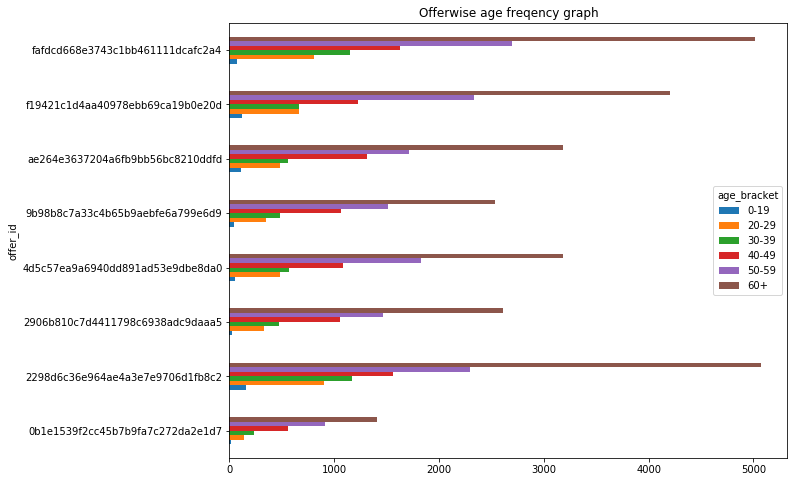

In [438]:
# Lets find out what makes our top offer (fafdcd668e3743c1bb461111dcafc2a4) different from others.
# Lets look at age wise distribution of transactions. 

t = c[c['offer_completed']==1].groupby(['age_bracket', 'offer_id']).count()['person']
t.unstack(level=0).plot(kind='barh', figsize=(10,8), title='Offerwise age freqency graph')

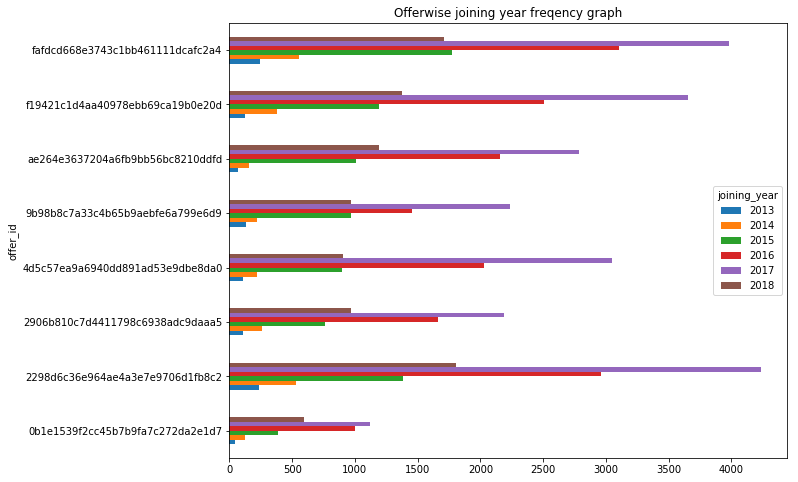

In [439]:
# Lets look at joining year wise distribution of transactions. 

t = c[c['offer_completed']==1].groupby(['joining_year', 'offer_id']).count()['person']
t.unstack(level=0).plot(kind='barh', figsize=(10,8), title='Offerwise joining year freqency graph')

##### Observation
- From the above graph it's evident that the top 2 offers are performing really well for 50+ demographics. 
    - And the top offer performs better than the second best because of slighly better conversion rate in the 50-59 category. 
- Maximum offers were completed by the users who joined in 2017 and followed by 2016.
- Users who joinined in 2018 were completing lesser number of offers compared to those who joined in 2016 and 2017.

In [440]:
# Unique list of offer ids.

list_of_offer_ids = list(portfolio_cleaned.id)
list_of_offer_ids

['ae264e3637204a6fb9bb56bc8210ddfd',
 '4d5c57ea9a6940dd891ad53e9dbe8da0',
 '3f207df678b143eea3cee63160fa8bed',
 '9b98b8c7a33c4b65b9aebfe6a799e6d9',
 '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 '2298d6c36e964ae4a3e7e9706d1fb8c2',
 'fafdcd668e3743c1bb461111dcafc2a4',
 '5a8bc65990b245e5a138643cd4eb9837',
 'f19421c1d4aa40978ebb69ca19b0e20d',
 '2906b810c7d4411798c6938adc9daaa5']

For the offer: ae264e3637204a6fb9bb56bc8210ddfd
Total number of offers sent: 11655
Total number of offers viewed: 11655 (100.0)
Total number of offers completed: 7362 (63.17)

Observations
For the age group 59+ the offer works better for female users. For others it works well for male.



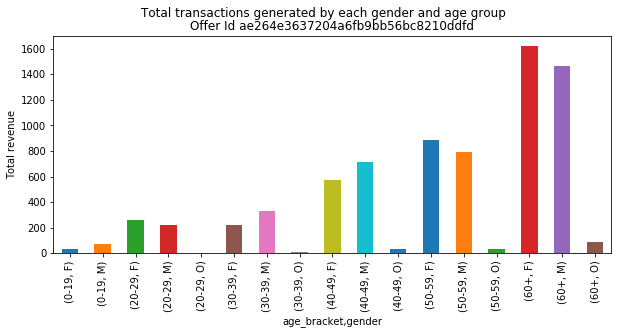

In [441]:
# offer wise analysis 
# Offer id - ae264e3637204a6fb9bb56bc8210ddfd

offer = 'ae264e3637204a6fb9bb56bc8210ddfd'
offer_df = c[c.offer_id == offer]
total_offer_offered = offer_df.groupby('offer_id')['offer_received'].sum()[0]
total_offer_viewed = offer_df.groupby('offer_id')['offer_viewed'].sum()[0]
total_offer_completed = offer_df.groupby('offer_id')['offer_completed'].sum()[0]

print(f'For the offer: {offer}')
print(f"Total number of offers sent: {total_offer_offered}")
print(f"Total number of offers viewed: {total_offer_viewed} ({round(total_offer_viewed / total_offer_offered * 100, 2)})")
print(f"Total number of offers completed: {total_offer_completed} ({round(total_offer_completed / total_offer_offered * 100, 2)})")

plt.figure(figsize=(10,4))
plt.suptitle('Total transactions generated by each gender and age group')
plt.title(f'Offer Id {offer}')
plt.xlabel('Age_bracket & gender')
plt.ylabel('Total revenue')
g = offer_df.groupby(['age_bracket', 'gender']).sum().copy()
#     print(g.head())
g['offer_completed'].plot(kind='bar')

print(f"""
Observations
============================
For the age group 59+ the offer works better for female users. For others it works well for male.
""")

For the offer: 4d5c57ea9a6940dd891ad53e9dbe8da0
Total number of offers sent: 12172
Total number of offers viewed: 12172 (100.0)
Total number of offers completed: 7196 (59.12)



Observations
For the age group 50+ the offer works better for female users. For others it works well for male.



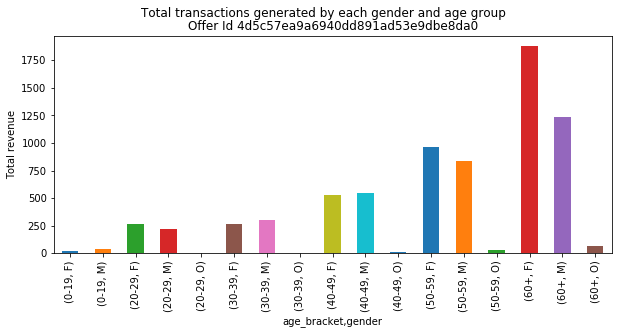

In [442]:
# offer wise analysis 
# Offer id - 4d5c57ea9a6940dd891ad53e9dbe8da0

offer = '4d5c57ea9a6940dd891ad53e9dbe8da0'
offer_df = c[c.offer_id == offer]
total_offer_offered = offer_df.groupby('offer_id')['offer_received'].sum()[0]
total_offer_viewed = offer_df.groupby('offer_id')['offer_viewed'].sum()[0]
total_offer_completed = offer_df.groupby('offer_id')['offer_completed'].sum()[0]

print(f'For the offer: {offer}')
print(f"Total number of offers sent: {total_offer_offered}")
print(f"Total number of offers viewed: {total_offer_viewed} ({round(total_offer_viewed / total_offer_offered * 100, 2)})")
print(f"Total number of offers completed: {total_offer_completed} ({round(total_offer_completed / total_offer_offered * 100, 2)})\n\n")

plt.figure(figsize=(10,4))
plt.suptitle('Total transactions generated by each gender and age group')
plt.title(f'Offer Id {offer}')
plt.xlabel('Age_bracket & gender')
plt.ylabel('Total revenue')
g = offer_df.groupby(['age_bracket', 'gender']).sum().copy()
#     print(g.head())
g['offer_completed'].plot(kind='bar')

print(f"""
Observations
============================
For the age group 50+ the offer works better for female users. For others it works well for male.
""")

For the offer: 3f207df678b143eea3cee63160fa8bed
Total number of offers sent: 5688
Total number of offers viewed: 5688 (100.0)
Total number of offers completed: 0 (0.0)

Observations
This offer didn't result in any transaction. We should stop sending this offer.



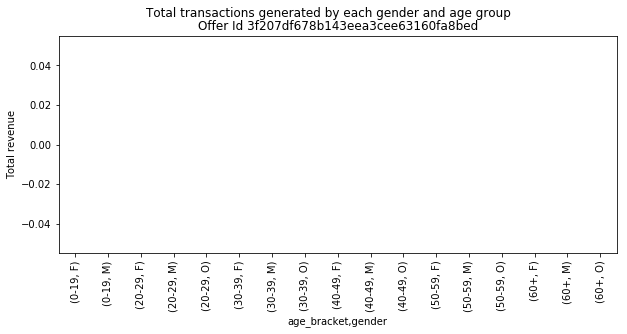

In [443]:
# offer wise analysis 
# Offer id - 3f207df678b143eea3cee63160fa8bed

offer = '3f207df678b143eea3cee63160fa8bed'
offer_df = c[c.offer_id == offer]
total_offer_offered = offer_df.groupby('offer_id')['offer_received'].sum()[0]
total_offer_viewed = offer_df.groupby('offer_id')['offer_viewed'].sum()[0]
total_offer_completed = offer_df.groupby('offer_id')['offer_completed'].sum()[0]

print(f'For the offer: {offer}')
print(f"Total number of offers sent: {total_offer_offered}")
print(f"Total number of offers viewed: {total_offer_viewed} ({round(total_offer_viewed / total_offer_offered * 100, 2)})")
print(f"Total number of offers completed: {total_offer_completed} ({round(total_offer_completed / total_offer_offered * 100, 2)})")

plt.figure(figsize=(10,4))
plt.suptitle('Total transactions generated by each gender and age group')
plt.title(f'Offer Id {offer}')
plt.xlabel('Age_bracket & gender')
plt.ylabel('Total revenue')
g = offer_df.groupby(['age_bracket', 'gender']).sum().copy()
#     print(g.head())
g['offer_completed'].plot(kind='bar')

print(f"""
Observations
============================
This offer didn't result in any transaction. We should stop sending this offer.
""")

For the offer: 9b98b8c7a33c4b65b9aebfe6a799e6d9
Total number of offers sent: 7663
Total number of offers viewed: 7663 (100.0)
Total number of offers completed: 5980 (78.04)

Observations
Except for user with age 60+ this offer works well for female users. For others it works well for male. 



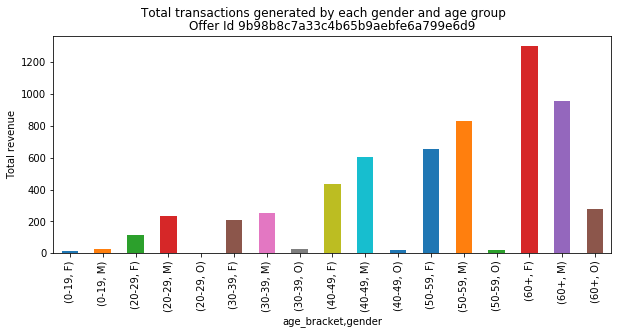

In [444]:
# offer wise analysis 
# Offer id - 9b98b8c7a33c4b65b9aebfe6a799e6d9

offer = '9b98b8c7a33c4b65b9aebfe6a799e6d9'
offer_df = c[c.offer_id == offer]
total_offer_offered = offer_df.groupby('offer_id')['offer_received'].sum()[0]
total_offer_viewed = offer_df.groupby('offer_id')['offer_viewed'].sum()[0]
total_offer_completed = offer_df.groupby('offer_id')['offer_completed'].sum()[0]

print(f'For the offer: {offer}')
print(f"Total number of offers sent: {total_offer_offered}")
print(f"Total number of offers viewed: {total_offer_viewed} ({round(total_offer_viewed / total_offer_offered * 100, 2)})")
print(f"Total number of offers completed: {total_offer_completed} ({round(total_offer_completed / total_offer_offered * 100, 2)})")

plt.figure(figsize=(10,4))
plt.suptitle('Total transactions generated by each gender and age group')
plt.title(f'Offer Id {offer}')
plt.xlabel('Age_bracket & gender')
plt.ylabel('Total revenue')
g = offer_df.groupby(['age_bracket', 'gender']).sum().copy()
#     print(g.head())
g['offer_completed'].plot(kind='bar')

print(f"""
Observations
============================
Except for user with age 60+ this offer works well for female users. For others it works well for male. 
""")

For the offer: 0b1e1539f2cc45b7b9fa7c272da2e1d7
Total number of offers sent: 4578
Total number of offers viewed: 4578 (100.0)
Total number of offers completed: 3269 (71.41)

Observations
For the age group 50+ the offer works better for female users. For others it works well for male.



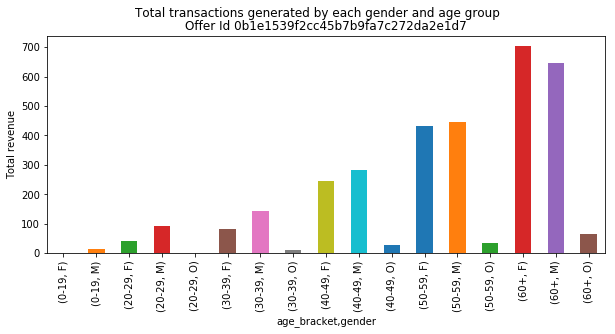

In [445]:
# offer wise analysis 
# Offer id - 0b1e1539f2cc45b7b9fa7c272da2e1d7

offer = '0b1e1539f2cc45b7b9fa7c272da2e1d7'
offer_df = c[c.offer_id == offer]
total_offer_offered = offer_df.groupby('offer_id')['offer_received'].sum()[0]
total_offer_viewed = offer_df.groupby('offer_id')['offer_viewed'].sum()[0]
total_offer_completed = offer_df.groupby('offer_id')['offer_completed'].sum()[0]

print(f'For the offer: {offer}')
print(f"Total number of offers sent: {total_offer_offered}")
print(f"Total number of offers viewed: {total_offer_viewed} ({round(total_offer_viewed / total_offer_offered * 100, 2)})")
print(f"Total number of offers completed: {total_offer_completed} ({round(total_offer_completed / total_offer_offered * 100, 2)})")

plt.figure(figsize=(10,4))
plt.suptitle('Total transactions generated by each gender and age group')
plt.title(f'Offer Id {offer}')
plt.xlabel('Age_bracket & gender')
plt.ylabel('Total revenue')
g = offer_df.groupby(['age_bracket', 'gender']).sum().copy()
#     print(g.head())
g['offer_completed'].plot(kind='bar')

print(f"""
Observations
============================
For the age group 50+ the offer works better for female users. For others it works well for male.
""")

For the offer: 2298d6c36e964ae4a3e7e9706d1fb8c2
Total number of offers sent: 13804
Total number of offers viewed: 13804 (100.0)
Total number of offers completed: 11153 (80.8)

Observations
For the age group 50+ the offer works equally well both male and female users.



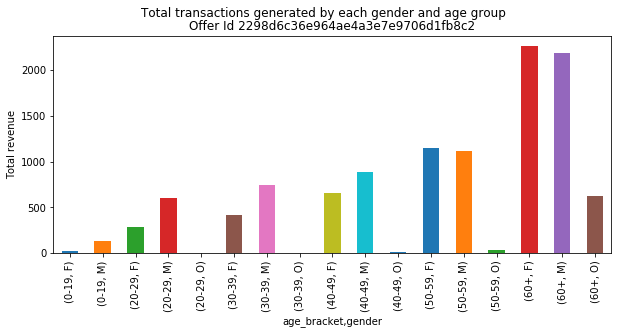

In [446]:
# offer wise analysis 
# Offer id - 2298d6c36e964ae4a3e7e9706d1fb8c2

offer = '2298d6c36e964ae4a3e7e9706d1fb8c2'
offer_df = c[c.offer_id == offer]
total_offer_offered = offer_df.groupby('offer_id')['offer_received'].sum()[0]
total_offer_viewed = offer_df.groupby('offer_id')['offer_viewed'].sum()[0]
total_offer_completed = offer_df.groupby('offer_id')['offer_completed'].sum()[0]

print(f'For the offer: {offer}')
print(f"Total number of offers sent: {total_offer_offered}")
print(f"Total number of offers viewed: {total_offer_viewed} ({round(total_offer_viewed / total_offer_offered * 100, 2)})")
print(f"Total number of offers completed: {total_offer_completed} ({round(total_offer_completed / total_offer_offered * 100, 2)})")

plt.figure(figsize=(10,4))
plt.suptitle('Total transactions generated by each gender and age group')
plt.title(f'Offer Id {offer}')
plt.xlabel('Age_bracket & gender')
plt.ylabel('Total revenue')
g = offer_df.groupby(['age_bracket', 'gender']).sum().copy()
#     print(g.head())
g['offer_completed'].plot(kind='bar')

print(f"""
Observations
============================
For the age group 50+ the offer works equally well both male and female users.
""")

For the offer: fafdcd668e3743c1bb461111dcafc2a4
Total number of offers sent: 13786
Total number of offers viewed: 13786 (100.0)
Total number of offers completed: 11360 (82.4)

Observations
For the age group 60+ the offer works well for female users. For others it works well for male.



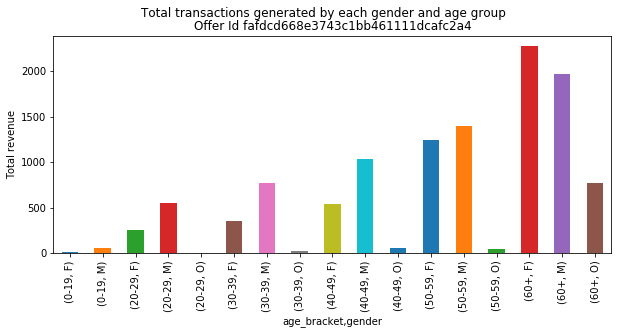

In [447]:
# offer wise analysis 
# Offer id - fafdcd668e3743c1bb461111dcafc2a4

offer = 'fafdcd668e3743c1bb461111dcafc2a4'
offer_df = c[c.offer_id == offer]
total_offer_offered = offer_df.groupby('offer_id')['offer_received'].sum()[0]
total_offer_viewed = offer_df.groupby('offer_id')['offer_viewed'].sum()[0]
total_offer_completed = offer_df.groupby('offer_id')['offer_completed'].sum()[0]

print(f'For the offer: {offer}')
print(f"Total number of offers sent: {total_offer_offered}")
print(f"Total number of offers viewed: {total_offer_viewed} ({round(total_offer_viewed / total_offer_offered * 100, 2)})")
print(f"Total number of offers completed: {total_offer_completed} ({round(total_offer_completed / total_offer_offered * 100, 2)})")

plt.figure(figsize=(10,4))
plt.suptitle('Total transactions generated by each gender and age group')
plt.title(f'Offer Id {offer}')
plt.xlabel('Age_bracket & gender')
plt.ylabel('Total revenue')
g = offer_df.groupby(['age_bracket', 'gender']).sum().copy()
#     print(g.head())
g['offer_completed'].plot(kind='bar')

print(f"""
Observations
============================
For the age group 60+ the offer works well for female users. For others it works well for male.
""")

For the offer: 5a8bc65990b245e5a138643cd4eb9837
Total number of offers sent: 9207
Total number of offers viewed: 9207 (100.0)
Total number of offers completed: 0 (0.0)

Observations
This offer didn't result in any transaction. We should stop sending this offer.



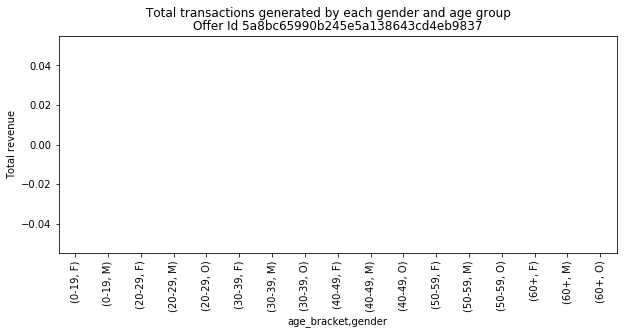

In [448]:
# offer wise analysis 
# Offer id - 5a8bc65990b245e5a138643cd4eb9837

offer = '5a8bc65990b245e5a138643cd4eb9837'
offer_df = c[c.offer_id == offer]
total_offer_offered = offer_df.groupby('offer_id')['offer_received'].sum()[0]
total_offer_viewed = offer_df.groupby('offer_id')['offer_viewed'].sum()[0]
total_offer_completed = offer_df.groupby('offer_id')['offer_completed'].sum()[0]

print(f'For the offer: {offer}')
print(f"Total number of offers sent: {total_offer_offered}")
print(f"Total number of offers viewed: {total_offer_viewed} ({round(total_offer_viewed / total_offer_offered * 100, 2)})")
print(f"Total number of offers completed: {total_offer_completed} ({round(total_offer_completed / total_offer_offered * 100, 2)})")

plt.figure(figsize=(10,4))
plt.suptitle('Total transactions generated by each gender and age group')
plt.title(f'Offer Id {offer}')
plt.xlabel('Age_bracket & gender')
plt.ylabel('Total revenue')
g = offer_df.groupby(['age_bracket', 'gender']).sum().copy()
#     print(g.head())
g['offer_completed'].plot(kind='bar')

print(f"""
Observations
============================
This offer didn't result in any transaction. We should stop sending this offer.
""")

For the offer: f19421c1d4aa40978ebb69ca19b0e20d
Total number of offers sent: 12733
Total number of offers viewed: 12733 (100.0)
Total number of offers completed: 9225 (72.45)

Observations
For the age group 50-59 the offer works well for female users. For others it works well for male.



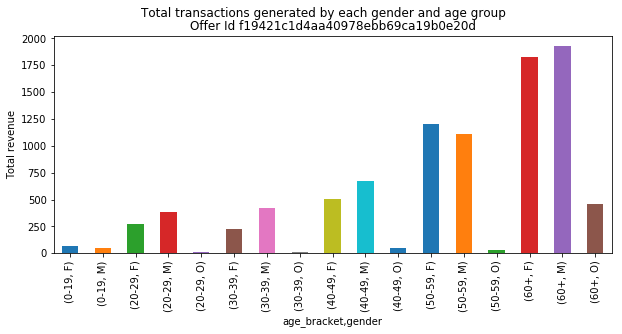

In [449]:
# offer wise analysis 
# Offer id - f19421c1d4aa40978ebb69ca19b0e20d

offer = 'f19421c1d4aa40978ebb69ca19b0e20d'
offer_df = c[c.offer_id == offer]
total_offer_offered = offer_df.groupby('offer_id')['offer_received'].sum()[0]
total_offer_viewed = offer_df.groupby('offer_id')['offer_viewed'].sum()[0]
total_offer_completed = offer_df.groupby('offer_id')['offer_completed'].sum()[0]

print(f'For the offer: {offer}')
print(f"Total number of offers sent: {total_offer_offered}")
print(f"Total number of offers viewed: {total_offer_viewed} ({round(total_offer_viewed / total_offer_offered * 100, 2)})")
print(f"Total number of offers completed: {total_offer_completed} ({round(total_offer_completed / total_offer_offered * 100, 2)})")

plt.figure(figsize=(10,4))
plt.suptitle('Total transactions generated by each gender and age group')
plt.title(f'Offer Id {offer}')
plt.xlabel('Age_bracket & gender')
plt.ylabel('Total revenue')
g = offer_df.groupby(['age_bracket', 'gender']).sum().copy()
#     print(g.head())
g['offer_completed'].plot(kind='bar')

print(f"""
Observations
============================
For the age group 50-59 the offer works well for female users. For others it works well for male.
""")

For the offer: 2906b810c7d4411798c6938adc9daaa5
Total number of offers sent: 7647
Total number of offers viewed: 7647 (100.0)
Total number of offers completed: 5956 (77.89)

Observations
For the age group 60+ the offer works well for female users. For others it works well for male.



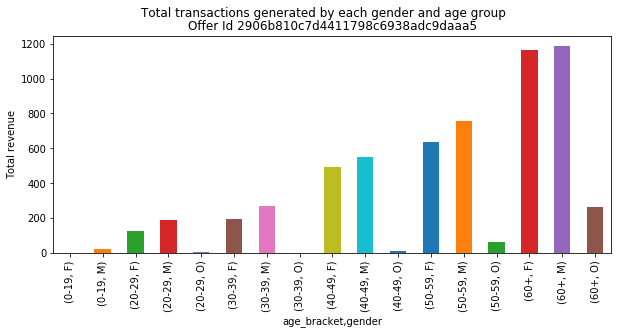

In [450]:
# offer wise analysis 
# Offer id - 2906b810c7d4411798c6938adc9daaa5

offer = '2906b810c7d4411798c6938adc9daaa5'
offer_df = c[c.offer_id == offer]
total_offer_offered = offer_df.groupby('offer_id')['offer_received'].sum()[0]
total_offer_viewed = offer_df.groupby('offer_id')['offer_viewed'].sum()[0]
total_offer_completed = offer_df.groupby('offer_id')['offer_completed'].sum()[0]

print(f'For the offer: {offer}')
print(f"Total number of offers sent: {total_offer_offered}")
print(f"Total number of offers viewed: {total_offer_viewed} ({round(total_offer_viewed / total_offer_offered * 100, 2)})")
print(f"Total number of offers completed: {total_offer_completed} ({round(total_offer_completed / total_offer_offered * 100, 2)})")

plt.figure(figsize=(10,4))
plt.suptitle('Total transactions generated by each gender and age group')
plt.title(f'Offer Id {offer}')
plt.xlabel('Age_bracket & gender')
plt.ylabel('Total revenue')
g = offer_df.groupby(['age_bracket', 'gender']).sum().copy()
#     print(g.head())
g['offer_completed'].plot(kind='bar')

print(f"""
Observations
============================
For the age group 60+ the offer works well for female users. For others it works well for male.
""")

# Conclusion

The problem that I chose to solve was to build a set of heuristics to help decide what offers works best for certain age and gender demographics. I chose a simple approach where the users who converted (completed offer) were analysed based on gender, age, and income bracket. 

At the end we create two user list, one of top user's user id list and the second user id list of potential customers based on transaction behavior, which can be used in re-marketing different products. And given the marketing cost these lists are helpful to target other products to true fans (First list) and use more offers to capture more revenue from the potential users (second list).

----------

### Observations

- Based on my analysis we observed that
 - Average user transactions count is 8.38
 - Average user age 62 years
 - Average user income 57000.
 
- Top three two age brackets and gender groups that result in highest number of transactions and in turn revenue are:
    - 60+ Male, 60+ Female
    - 50-59 Male, 50-59 Female
    - 40-49 Male, 40-49 Female
- There is not much difference in income gap between the users who transact based on their age, and gender groups.
    
    
- 3 out of 5 top offers 
    - were discount offers. And they had high difficulty but low reward.
    - were sent on all 4 channels. 
- 2 out of 5 top offers were bogo offers with medium difficulty and medium reward. 


- Highest offer completion rate (conversion rate) is for the offer: **_fafdcd668e3743c1bb461111dcafc2a4_** (~82%). 
    - We should send this offer more. 
- We also observed that the top 2 offers are performing really well for 50+ demographics. 
    - And the top offer performs better than the second best because of slightly better conversion rate in the 50-59 category. 
- Maximum offers were completed by the users who joined in 2017 and followed by 2016.
- Users who joined in 2018 were completing lesser number of offers compared to those who joined in 2016 and 2017.


#### Metric for selecting top offer 
For selecting the top offers the metrics we are going to use is the offers which has highest completion rate (conversion rate). As intuitively, we know that the more the conversions the more the revenue increases. 

Based on above metrics:
  - Top Three offers
       - fafdcd668e3743c1bb461111dcafc2a4
       - 2298d6c36e964ae4a3e7e9706d1fb8c2
       - 9b98b8c7a33c4b65b9aebfe6a799e6d9


  - The below mentioned offers didn't result in any conversion. We should stop sending these particular offers. 
     1. 3f207df678b143eea3cee63160fa8bed
     2. 5a8bc65990b245e5a138643cd4eb9837
 
See the individual offerwise metrics and observations above. 

### Recommendations
- Send the top three offers more, especially for 
    - users who joined in 2016-2017
    - users in the age group 50+
- Send offers in all 4 channels for better conversions. 
- Test and optimise the below mentioned two categories (based on offer type) for better conversions
    - different discount offers with high difficulty and low reward.
    - different bogo offers with medium difficulty and medium rewards
- stop sending below mentioned offers.
     1. 3f207df678b143eea3cee63160fa8bed
     2. 5a8bc65990b245e5a138643cd4eb9837

-------------
### NOTES
 - We have also created top converting user list (total Ids 3941). This list was based on the users who were in the 75% percentile of the conversion counts of all the users.
   - These users are like 1000 true fans. 
   - They enjoy the product & we need not send offers to them.
 - We have also created least converting user list (total Ids 4037). This list was based on the users who were in the 25% percentile of the conversion counts of all the users.
   - These users have converted but has potential to convert more. 
   - These user ids can be used for remarketing by offering better offers so that they convert more.
   
_Next steps include building a simple machine learning model to predict the users who has high chance of conversion (completing the offers) based on offer viewed and completed data._